In [1]:
##INPUT description
#
#This script requires two input files: 
#- the summary of the Benchflow tests ("dataFile") and 
#- the output file of the APM tools ("operational_profile")
#
#The Benchflow tests must be run with Users==50,100,150,200,250,300 and the following 
#configurations:
#
# Memory CPU  Replicas
#    1.0 0.50 2
#    0.5 0.25 4
#    0.5 0.50 2
#    0.5 0.25 2
#    0.5 0.50 1
#    1.0 0.50 4
#    0.5 0.50 4
#    1.0 0.25 2
#    0.5 0.25 1
#    1.0 0.25 4
#    1.0 0.50 1
#    1.0 0.25 1
#
#To define the benchmark threshold, an additional test in Benchflow 
#must be run with Users=2, Memory=4 CPU=1 and Replicas=1
#
#dataFile must contains all the above tests, no matter the order
#dataFile has the following entry layout: ID,Users,Memory,CPU,CartReplicas,Metric,Microservice
#Metric has three possible string values: "Avg (sec)", "SD (sec)" and "Mix % (take failure into account)" 
#Microservice is the name of the microservice
#
#operational_profile has the following entry layout: State - number of concurrent users,Frequency 
#



In [2]:
install.packages("RColorBrewer", repos='http://cran.us.r-project.org')
install.packages("gridExtra")
install.packages("getPass")
install.packages("RPostgreSQL")

library("RColorBrewer")
library(ggplot2)
library(gridExtra)
library(getPass)
library(RPostgreSQL)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: DBI



In [3]:
db_connection <- DBI::dbConnect(dbDriver(drvName = "PostgreSQL"), dbname = Sys.getenv("DB_NAME"), host=Sys.getenv("HOST_NAME"), port="5432", user=Sys.getenv("POSTGRES_USERNAME"), password=Sys.getenv("POSTGRES_PASSWORD"))  

In [4]:
project_id = "1628ba4d-8900-41a6-88a3-2c0868b53566"

raw_data_content = readLines("experiments_0.5_and_1GB_benchflow_output.csv")
raw_data <- read.csv(textConnection(raw_data_content), header=TRUE, sep=";", dec = ",")
tests <- unique(raw_data[,c(1,3)])

max_no_of_users <- max(raw_data[,3])
min_no_of_users <- min(raw_data[,3])

sql_operational_profile = "SELECT users, frequency FROM operational_profile_data WHERE operational_profile = (SELECT id FROM operational_profiles WHERE project = ?project)"
operational_profile <- dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_operational_profile, project = project_id))

user_load <- operational_profile[,1]
access_count <- operational_profile[,2]
max_no_of_requests <- max(user_load)
scale_factor <- max_no_of_users/max_no_of_requests
scaled_user_load <- floor(scale_factor * user_load)

tests

Warning message in readLines("experiments_0.5_and_1GB_benchflow_output.csv"):
“incomplete final line found on 'experiments_0.5_and_1GB_benchflow_output.csv'”


,TestID,Users
,<int>,<int>
1,1,150
4,2,300
7,1,250
10,3,50
13,4,300
16,1,100
19,1,300
22,5,100
25,6,50


In [5]:
##Create aggregate values (by fifty) of the user frequency from "operational_profile" 

calculate_aggregated_values <- function() {    
    access_frequency <- access_count/sum(access_count)
    by_fifty <- which(scaled_user_load %% 50 == 0)
    no_of_aggregated_rows = length(by_fifty)

    binProb <- c()
    for (i in 1:no_of_aggregated_rows) {
        if (i==1) {
            binProb[i] <- sum(access_frequency[1:by_fifty[i]])
        } else {
            binProb[i] <- sum(access_frequency[(by_fifty[i-1]+1):by_fifty[i]])
        }
    }

    matrix(c(scaled_user_load[by_fifty], binProb), ncol=2, nrow=no_of_aggregated_rows, dimnames=list(c(1:no_of_aggregated_rows), c("Workload (number of users)", "Domain metric per workload")))
}

aggregated_values_from_operational_profile <- calculate_aggregated_values()
aggregated_values_from_operational_profile

,Workload (number of users),Domain metric per workload
1,50,0.10582011
2,100,0.18518519
3,150,0.22222222
4,200,0.22222222
5,250,0.20370370
6,300,0.06084656


In [6]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

calculate_threshold <- function() {
    data_of_min_user<-raw_data[raw_data$Users==min_no_of_users,]
    test_of_min_user<-tests[tests$Users==min_no_of_users,]

    avg <-data_of_min_user[data_of_min_user$Metric=="Avg (sec)",][,-c(1:4)]
    sd <- data_of_min_user[data_of_min_user$Metric=="SD (sec)",][,-c(1:4)]
    
    data.frame(test_of_min_user,avg+3*sd)
}

threshold<-calculate_threshold()

#Check the first line of the dataframe thereshold: it must be one line
head(threshold)

,TestID,Users,createOrder,basket,getCatalogue,getItem,getCart,login,getOrders,catalogue,⋯,tags,getCustomer,viewOrdersPage,cataloguePage,getRelated,addToCart,catalogueSize,getAddress,getCard,showDetails
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
205,13,2,0.03,0.002,0.008,0.027,0.074,0.089,0.026,0.002,⋯,0.016,0.027,0.005,0.008,0.034,0.005,0.024,0.034,0.008,0.002


In [7]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

tests_without_benchmark<-tests[!tests$Users==min_no_of_users,]
raw_data_without_benchmark<-raw_data[!raw_data$Users==min_no_of_users,]

avg<-raw_data_without_benchmark[raw_data_without_benchmark$Metric=="Avg (sec)",-4]
sd<-raw_data_without_benchmark[raw_data_without_benchmark$Metric=="SD (sec)",-4]
mix<-raw_data_without_benchmark[raw_data_without_benchmark$Metric=="Mix % (take failure into account)",-4]

#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
pass_criteria<-avg
relative_mass<-c()

no_of_microservices<-ncol(raw_data)-4
mix_of_passing_tests<-as.data.frame(matrix(nrow=nrow(tests_without_benchmark), ncol=ncol(raw_data_without_benchmark)-1))

for(j in 1:nrow(pass_criteria)){
    mix_of_passing_tests[j,]<-mix[j,]
    for(i in 4:(3+no_of_microservices)){
        if(pass_criteria[j,i]>threshold[i-1]){mix_of_passing_tests[j,i]<-0}
    }
    relative_mass[j]<-sum(mix_of_passing_tests[j,4:(3+no_of_microservices)])
}

#Show first lines of passCriteria
relative_mass


[1] 0.5304 0.6048 0.2262 0.9999 0.2262 1.0001 0.2258 1.0001 1.0000 0.7480
[11] 0.3918 0.7474 0.2260 0.5305 0.2262 0.6175 1.0001 1.0000 0.5300 0.9999
[21] 1.0000 0.2262 0.2260 0.1959 0.5623 0.2259 1.0003 0.9998 0.5304 0.9999
[31] 0.2258 0.9999 0.2261 0.9998 0.7484 0.2261 0.2259 0.2134 0.4350 0.6440
[41] 0.2262 1.0002 0.2263 0.7485 1.0003 0.5917 0.9999 0.2261 0.7497 0.2261
[51] 0.9999 0.2262 0.2264 0.2262 1.0000 0.2259 0.2261 0.6434 0.7482 0.9999
[61] 1.0000 0.5181 0.2262 1.0001 0.7485 1.0000 0.2130 0.2262 0.7481 0.2260
[71] 0.2259 0.6435

In [8]:
#Compute the domain metric for each configuration
tempData<-tests_without_benchmark
tempData$relative_mass<-relative_mass

absolute_mass<-c()
for(j in 1:nrow(tempData)){
    absolute_mass[j]<-tempData[j,"relative_mass"]*aggregated_values_from_operational_profile[match(tempData[j,"Users"], aggregated_values_from_operational_profile[,1]),2]
}
tempData$absolute_mass<-absolute_mass
mySettingsUnique<-unique(tempData[1])

set<-list()
domainMetricList<-list()
for(i in 1:nrow(mySettingsUnique)){
    set[[i]]<-tempData[which(tempData[,1] == mySettingsUnique[i,1]),]
    domainMetricList[[i]]<-set[[i]][,c(2,4)][order(set[[i]][,c(2,4)][,1]),]
}

#Uncomment this to show first lines of domainMetricList
#head(domainMetricList)

[1] "Cumulative Domain Metric"


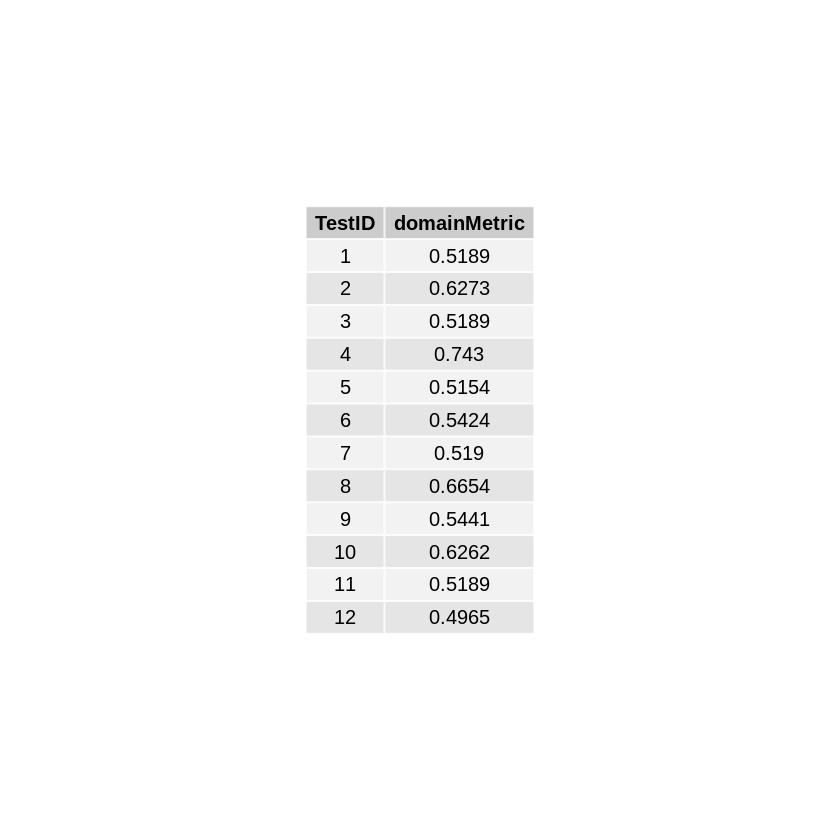

In [11]:
#Compute Cumulative Domain metric: summing up absoluteMass over users for each configuration
mySettingsUnique$domainMetric<-0
for(i in 1:nrow(mySettingsUnique)){
    mySettingsUnique[i,2]<-round(sum(tempData[which(tempData[,1] == mySettingsUnique[i,1]),"absolute_mass"]),4)
}
domainMetric<-mySettingsUnique
#Uncomment the following lines to save the Table
#pdf("Table.pdf", height=5, width=5)

p<-tableGrob(domainMetric, rows=NULL)
grid.arrange(p)
#dev.off()
print("Cumulative Domain Metric")

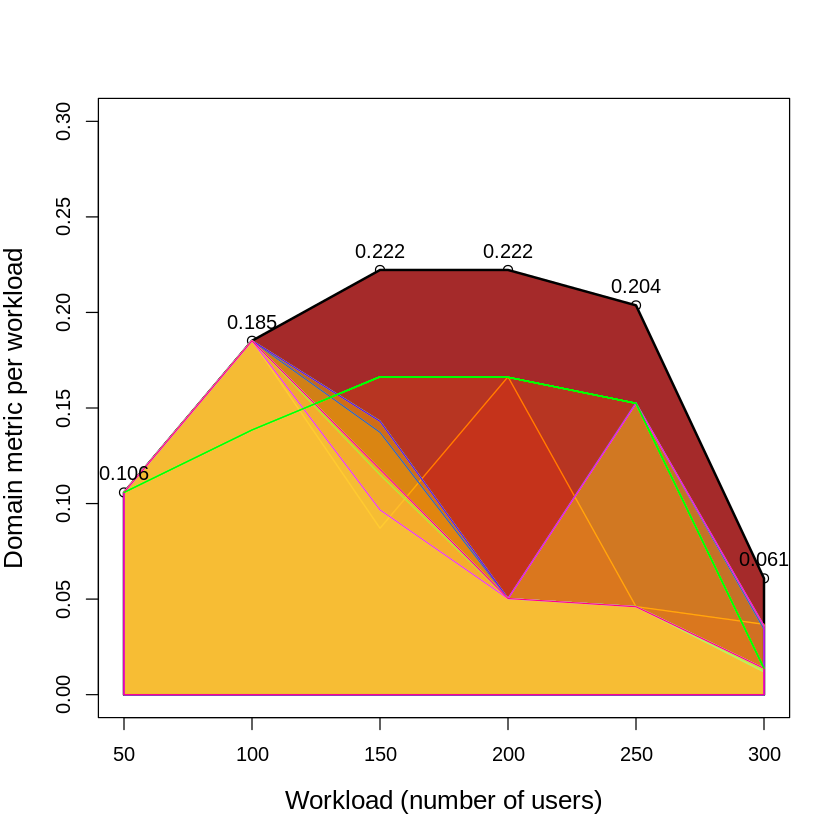

In [17]:
#Plot operational_profile against domain metric for each configuration

plot(aggregated_values_from_operational_profile, xlim=c(50, 300), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(50,aggregated_values_from_operational_profile[,1],300),c(0,aggregated_values_from_operational_profile[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

sortedDomainMetric<-domainMetric
k<-which(sortedDomainMetric[,2]==max(sortedDomainMetric[,2]))
#Green line whithin the polygon is the best domain matric line. 
#It corresponds to the second line in the final table below
for(i in 1:nrow(mySettingsUnique)) {
    lines(domainMetricList[[i]], type="l", col=heat.colors(11)[i])
    lines(domainMetricList[[k]], type="l", col="green")
    polygon(c(50,t(domainMetricList[[i]][1]),300),c(0,t(domainMetricList[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregated_values_from_operational_profile,labels = round(aggregated_values_from_operational_profile[1:6,2],3), pos=3, col="black")

#graphics.off()

new("refMethodDef", .Data = function (save = "default", status = 0, 
    runLast = TRUE) 
{
    save <- switch(save, default = , yes = TRUE, no = FALSE, 
        ask = ask("Save workspace image? [y/n/c]: "), stop("unknown `save` value"))
    if (is.null(save)) 
        return()
    if (runLast) {
        if (!is.null(.GlobalEnv$.Last)) 
            .GlobalEnv$.Last()
        if (!is.null(.GlobalEnv$.Last.sys)) 
            .GlobalEnv$.Last.sys()
    }
    if (save) 
        NULL
    payload <<- c(.self$payload, list(list(source = "ask_exit", 
        keepkernel = FALSE)))
}, mayCall = character(0), name = "quit", refClassName = "Executor", 
    superClassMethod = "")
<environment: 0x5557580c3110>
attr(,"mayCall")
character(0)
attr(,"name")
[1] "quit"
attr(,"refClassName")
[1] "Executor"
attr(,"superClassMethod")
[1] ""
attr(,"class")
[1] "refMethodDef"
attr(,"class")attr(,"package")
[1] "methods"

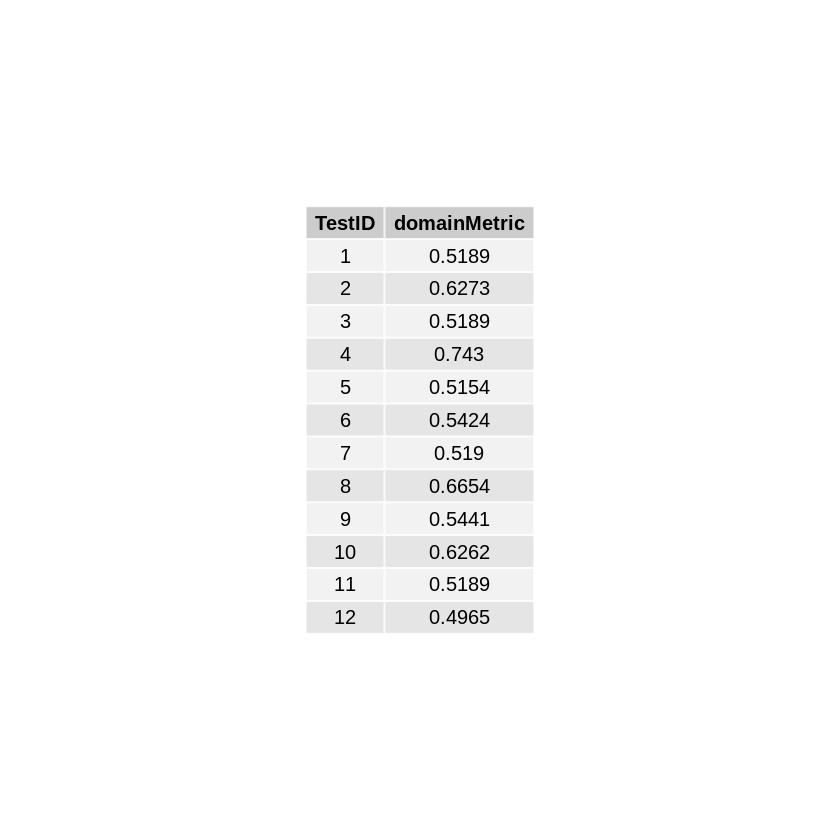

In [18]:
par(mfrow=c(2,1))
grid.arrange(p)
q

In [ ]:
DBI::dbDisconnect(db_connection)